In [45]:
from psaw import PushshiftAPI
import praw
from prawcore import Forbidden
from praw.exceptions import ClientException
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

from scipy import stats

from pymongo import MongoClient, errors

from bson.json_util import loads, dumps
from bson.objectid import ObjectId

from datetime import datetime as dt

import boto3

import time

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix

from imblearn.ensemble import BalancedRandomForestClassifier

import pickle

from scipy import interp

import string
from pprint import pprint

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
porter = PorterStemmer()
wordnet = WordNetLemmatizer()

In [4]:
creds = {}
with open ('/opt/cap1/.cap1', 'r') as fp:
    for line in fp:
        k, v = line.replace('\n','').split('\t')
        creds[k] = v

In [5]:
reddit = praw.Reddit(client_id=creds['REDDIT_ID'], 
    client_secret=creds['REDDIT_SECRET'],
    password=creds['REDDIT_PASSWORD'], 
    username=creds['REDDIT_USERNAME'],
    user_agent='accessAPI:v0.0.1 (by /u/{})'.format(creds['REDDIT_USERNAME']))

In [6]:
api = PushshiftAPI()

In [7]:
client = MongoClient('localhost', 27017)
db = client['cap2']

In [8]:
# get all comments into a list called 'docs', then make dataframe
query = {}
fields = { '_id': 0 }
# docs is about 1.3 GB in RAM
docs = list(db['comment'].find( query, fields ))

In [9]:
comms = pd.DataFrame(docs)

In [ ]:
# TODO add submission ids to the set of ids from trolls, probably append 't1_' to comments
# for ease of use

## assign labels, 'troll?', and 'child_of_troll?', and 'parent_of_troll?'

In [10]:
# create array of classes for target
classes = ['other', 'parent', 'child', 'troll']

In [11]:
# assign the label, 'troll?'' to each comment
troll_comment_ids_set = set(comms[~comms['author'].isna()]['id'])
comms['troll?'] = [int(mybool) for mybool in [
                    commid in troll_comment_ids_set for commid in comms['id']
                    ]]
np.sum(comms['troll?'])

6704

In [12]:
# is this comment in reply to a troll?
comms['child_of_troll?'] = [int(mybool) for mybool in [
                    pid.split('_')[1] in troll_comment_ids_set for pid in comms['parent_id']
                    ]]
np.sum(comms['child_of_troll?'])

2985

### only 57, praw never gave us children of troll comments...the only ones we have are from trolls replying to trolls

#### FIXED, used praw to get the troll comments, then used .refresh() to load the replies. worked ok

In [13]:
# did a troll reply to this?
troll_parent_ids_set = set(
                            [p.split('_')[1] for p in comms[~comms['author'].isna()]['parent_id']]
                        )
comms['parent_of_troll?'] = [int(myid in troll_parent_ids_set) for myid in comms['id']]

np.sum(comms['parent_of_troll?'])

1824

In [14]:
np.unique([p.split('_')[0] for p in np.unique(comms[~comms['author'].isna()]['parent_id'])], return_counts=True)

(array(['t1', 't3'], dtype='<U2'), array([1839, 4348]))

#### hm, 1144 comments are parents of trolls, but there are 1839 't1'-style parent_ids among troll comments. Which of the unique parent ids aren't getting labeled as parent?

#### FIXED, got all of them except 15. Seems like reddit praw is a bit stingy when it comes to providing all comments in a thread, perhaps especially around trolls. Could make a test for that

In [15]:
parent_ids = np.unique(comms[~comms['author'].isna()]['parent_id'])
len(parent_ids)

6187

In [16]:
t1_parent_ids=[]
for p in parent_ids:
    if p[:2]=='t1':
        t1_parent_ids.append(p.split('_')[1])
set_parent_ids = set(t1_parent_ids)
set_parent_of_troll = set(comms[comms['parent_of_troll?']==1]['id'])
# how does a differ from 
len(set_parent_ids), len(set_parent_of_troll)

(1839, 1824)

In [17]:
# here are the 695 comment ids that probably need to be set as parent_of_troll
missing_commentids = np.array(t1_parent_ids)[[myid not in set_parent_of_troll for myid in t1_parent_ids]]

In [18]:
# are these comments simply missing from the data? YES
# FIXED, only 15 remain after starting with 1824 ish
num_hits = []
for cid in missing_commentids:
    num_hits.append(len(comms[comms['id']==cid]))
np.unique(num_hits, return_counts=True)

(array([0]), array([15]))

In [19]:
len(missing_commentids)

15

In [20]:
def printall(pd_obj):
    '''
    print every row and column in a pandas object
    '''
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(pd_obj)

In [ ]:
# print the first non-troll comment, making sure to 
r = np.where(comms['author'].isna())
printall(comms.iloc[r[0], :].iloc[0,:])

In [21]:
for coll in db.list_collection_names():
    print(f'{coll:14}: {db[coll].count_documents({}):6}')

submission    :  14523
first_and_last:    964
comment       : 234008


In [ ]:
# top-up the parent comments, worked great.
log = [] 
i = 0 # had clientexception at 59, id='cqe9a6b'
for comment_id in missing_commentids[i:]: 
    i += 1 
    print(f'searching for comment id: {comment_id}') 
    comment = reddit.comment(id=comment_id) 
    try: 
        comment._fetch() 
    except (Forbidden, ClientException): 
        log.append(i) 
        continue 
    d = dict(vars(comment)) 
    for key in ['_replies', '_submission', 
            '_reddit', 'mod', 'author', 
            'subreddit']: 
        _ = d.pop(key, None) 
    try: 
        db['comment'].insert_one(d) 
    except (errors.DuplicateKeyError, errors.InvalidDocument): 
        log.append[i] 
        continue 

In [22]:
for coll in db.list_collection_names():
    print(f'{coll:14}: {db[coll].count_documents({}):6}')

submission    :  14523
first_and_last:    964
comment       : 234008


In [ ]:
# these are the before and after numbers of records in mongo
# 15 records failed
num_records_added = 231533 - 230853
num_records_added

In [ ]:
# from the ipython session in which I ran the scrape
log = [59, 63, 84, 98, 109, 187, 500, 580, 632, 667, 670, 676, 678, 684, 689]
missing_commentids[log]

### cqhtj4q
```
[–]zenzog3 points 5 years ago 
https://mobile.twitter.com/shoxCSGO/status/588523685419601922
permalink save report give gold reply
```
https://snew.notabug.io/r/csgobetting/comments/3324gu/envyus_vs_dignitas_bo3_190415_2100_cest/cqhtj4q/

### d4ssri9
```
[–][censored]3 points 4 years ago 
[censored]
permalink save report give gold reply[removed by moderators]
```
https://snew.notabug.io/r/rage/comments/4qgm68/woman_26_wielded_hatchet_after_her_demands_for/d4ssri9/

### dp9fs27
```
–][deleted]2 points 3 years ago 
[deleted]
permalink save report give gold reply
```
https://snew.notabug.io/r/Sissies/comments/7ad3vx/any_requests/dp9fs27/

In [23]:
# get the replies to the trolls
# get missing comments from pushshift
troll_commentids = comms[~comms['author'].isna()]['id']
np.random.choice(troll_commentids)

'd91i52j'

In [ ]:
# top-up the child comments, worked great
log = [] 
i = 0 
for comment_id in troll_commentids:  
    i += 1  
    print(f'searching for comment id: {comment_id}')  
    comment = reddit.comment(id=comment_id)  
    try:  
        comment.refresh() 
    except (Forbidden, ClientException):  
        log.append(i)  
        continue 
    for reply in comment._replies: 
        d = dict(vars(reply)) 
        did = d['id'] 
        print(f'found reply id: {did}')  
        for key in ['_replies', '_submission',  
                '_reddit', 'mod', 'author',  
                'subreddit']:  
            _ = d.pop(key, None)  
        try:  
            db['comment'].insert_one(d) 
        except (errors.DuplicateKeyError, errors.InvalidDocument): 
            log.append(i)  
            continue 

In [ ]:
# 234008 comments after first child run, steady after re-run so far...30 min or so
for coll in db.list_collection_names():
    print(f'{coll:14}: {db[coll].count_documents({}):6}')

In [ ]:
records_added = 234008 - 231533
records_added

## NLP

In [24]:
orig_stopwords_ = set("a,able,about,across,after,all,almost,also,am,among,an,and,any,\
are,as,at,be,because,been,but,by,can,could,dear,did,do,does,either,\
else,ever,every,for,from,get,got,had,has,have,he,her,hers,him,his,\
how,however,i,if,in,into,is,it,its,just,least,let,like,likely,may,\
me,might,most,must,my,neither,no,of,off,often,on,only,or,other,our,\
own,rather,said,say,says,she,should,since,so,some,than,that,the,their,\
them,then,there,these,they,this,tis,to,too,twas,us,wants,was,we,were,\
what,when,where,which,while,who,whom,why,will,with,would,yet,you,your,u,s".split(','))

# new stopwords after first run through
# sws_to_add_brf1 = 'thanks,op,tie,deleted,game,crypto,invest,\
# edit,platform,play,giveaway,ok,yeah,blockchain,enter,remove,\
# m,token,awesome,ethereum,exchange,steam,dude'.split(',')

# stopwords_ = set(list(orig_stopwords_) + sws_to_add_brf1)
stopwords_ = orig_stopwords_

punctuation_ = set(string.punctuation + '’' + '“')

def rm_punctuation(a_string):
    table = str.maketrans('', '', ''.join(punctuation_))
    return a_string.translate(table)
        
def tokens_lower(tokens):
    return [word.lower() for word in tokens]

def filter_tokens(tokens):
#     for w in sent: print(w)
#     if w == "’": print("this is ': " + w)
    return [w for w in tokens if not w in stopwords_]

def stem_tokens(ntlk_stem_obj, tokens):
    # visualize what stemming and lemmitization does!
    # str(porter.__class__) = "<class 'nltk.stem.porter.PorterStemmer'>"
#     name = str(ntlk_stem_lemm_obj.__class__).split("'")[1].split('.')[-1]
#     count_ident = 0
#     count_alter = 0
    return [ntlk_stem_obj.stem(tok) for tok in tokens]
#     elif ''
# for tok in tokens:
#         return ntlk_stem_lemm_obj.stem(tok)
#         if tok == stem_lemm_f_l_tok:
#             count_ident += 1
#         else:
#             print(tok, stem_lemm_f_l_tok)
#             count_alter += 1
#     print('{}:\nNumber of unchanged words: {}\nchanged words: {}\n'.format(name, count_ident, count_alter))

def lemm_tokens(ntlk_lemm_obj, tokens):
    return [ntlk_lemm_obj.lemmatize(tok) for tok in tokens]

In [25]:
def nlp_pre_proc_doc(input_string, stemming=False):
    '''
    given document:
        tokenizes the document
        sets tokens to lower case
        filters punctuation and stop words from tokens
        returns porter, snowball, and wordnet stem/lemm tokens
    '''
    no_punct_string = rm_punctuation(input_string)
    tokens = word_tokenize(no_punct_string)
    lo_tokens = tokens_lower(tokens)
    f_lo_tokens = filter_tokens(lo_tokens)
    if stemming:
        s_f_lo_tokens = stem_tokens(porter, f_lo_tokens)
        le_s_f_lo_tokens = lemm_tokens(wordnet, s_f_lo_tokens)
        return ' '.join(le_s_f_lo_tokens)
    else:
        le_f_lo_tokens = lemm_tokens(wordnet, f_lo_tokens)
        return ' '.join(le_f_lo_tokens)

In [26]:
# this takes a few minutes, and uses about 100 MB of RAM
corpus = [nlp_pre_proc_doc(d) for d in comms['body']]

#### so, let's recap the tomfoolery between praw and psaw
0) psaw returns comments from trolls, praw does not ... true? FALSE, psaw doesn't give results when parent_id is from a troll
1) psaw returns nothing when searching on threads with comments from trolls ... true? mostly. I believe it's not 100%, but e.g. https://api.pushshift.io/reddit/submission/comment_ids/4rdu5x returns []
2) re: 1, reddit does, but does not include any responses to the trolls ... true?

#### TODO
* classify on pca / increase the number of maximum features per tree
* data completeness
  - do we have all comments multiple levels below troll comments?
  - authors, subreddits, link- and comment-karma
  - permalink
* one-hot encode the subreddit to add to the tfidf
* add user activity profile to the tfidf
* inspect models for most important features
* start with id, (comment)
  - is the comment trollish? proba > threshold
  - if yes, then 
    - classify all other comments from the user (max=1000?)
    - for each trollish comment, recurse on other trollish comments in its thread (max=1000?)
  - given all the comments (including non-trollish from threads), view the author creation date and test for spike


#### join the [71.6 million usernames](https://old.reddit.com/r/pushshift/search?q=karma&restrict_sr=on&sort=relevance&t=all) to the user activity dataframe so we can efficiently load the link and comment karma of all these users into mongo
```bash
comm <(\
    sed '1d' user_activity_dataframe.csv | cut -d, -f2 | sort -u\
    ) \
    <(\
    cut -d, -f1 user_activity_dataframe_reddit_accounts.csv | sort -u\
    ) | 
awk -F"\t" '{print NF;}' | sort | uniq -c
```
``` 
    56 1
   277 3
```

### record ids for comments with neither depth nor nest_level

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(comms[[not value for value in comms['nest_level'].isna()]].head())
    for i, row in enumerate(comms[['nest_level', 'depth']].values):
        print(i, all([np.isnan(val) for val in row]))

#### For the purposes of combining the depth and the nest_level, 750 comments have neither a depth nor a nest_level. They are all from trolls. With a few dozen exceptions, all have parent_ids starting with t3, meaning they have depth=1

## TODONE
* data completeness
  - get nest_level for everything

* classify using extra features from comments metadata
  - normalized depth
  - controversiality
  - score

* what is the human readable subreddit given the fullname, eg. t5_2r99w (DONE)
```python
gen = reddit.subreddits.search("t5_2r99w,t5_2r99w")
next(gen), next(gen)
```
```
(Subreddit(display_name='whisky'),
 Subreddit(display_name='BaseballbytheNumbers'))
```
* get user link and comment karma (partially done - https://old.reddit.com/r/pushshift/comments/9i8s23/dataset_metadata_for_69_million_reddit_users_in/)
 - still missing karma for 623 userids
```bash
$ wc -l data/user_activity_dataframe*
  3826 data/user_activity_dataframe.csv
  3203 data/user_activity_dataframe_RA_2018-09.csv
  3199 data/user_activity_dataframe_reddit_accounts.csv
 10228 total
```
* how to get the permalink for each comment (DONE)
```python
comment = reddit.comment(id="dxolpyc")
comment.permalink
```
```
'/r/redditdev/comments/8dmv8z/is_there_no_distinguish_method_for_comments_in/dxolpyc/'
```
* what is the author given its id? e.g. t2_105z8m (DONE)
```python
str(reddit.redditor(fullname="t2_z919g"))
```
```
'BlackToLive'
```
* is their greater controversiality in troll comments than others? (DONE)
  - yes, slightly -- 4% to 3%
* retrieve missing comments
  - parents of trolls (missing 695, ~50%) (DONE)
  - replies to trolls (missing ALL of them, unless the reply is from a troll) (DONE)

## engineer feature: norm_nest_level
#### currently there are 1430 comments with neither a 'nest_level' nor a 'depth'

### check assumptions
1) all depths/nest_levels are 0 for parent_id~t3_* (DONE, TRUE)

In [ ]:
# get index into the rows with neither depth, nor nest_level
no_depth_index = np.logical_and(np.isnan(comms['nest_level']), np.isnan(comms['depth']))

In [ ]:
len(comms[no_depth_index])

In [ ]:
# this could be part of a class, EngineerFeature?
def eng_depth_add_type_of_parent(df):
    '''
    adds column for type of parent (t3 or t1)
    
    e.g. given df
        depth nest_level   parent_id
          NaN        7.0  t1_d4quv2y
    updates df to
        depth  nest_level   parent_id  comm_type
          NaN         7.0  t1_d4quv2y        t1
    '''
    outcols = list(df.columns) + ['comm_type']
    # allow for extra columns after depth, nest_level, and parent_id
    if list(df.columns)[:3] != ['depth', 'nest_level', 'parent_id']:
        raise
    outdf = pd.DataFrame(np.hstack([
        df.values, 
        np.array([
            x.split('_')[0] for x in df['parent_id'].values
        ])
        .reshape(-1, 1)
    ]), columns=outcols)
    outdf['depth'] = outdf['depth'].astype(float)
    outdf['nest_level'] = outdf['nest_level'].astype(float)
    if 'troll?' in outcols:
        outdf['troll?'] = outdf['troll?'].astype(int)
    return outdf

In [ ]:
# logical not the index to get the comments with one or the other
has_depth_trimdf = comms[~no_depth_index][['depth', 'nest_level', 'parent_id']]
has_depth_trimdf

In [ ]:
# create new dataframe containing column for type of comment (parent is thread or other comment)
comm_type_has_depth_trimdf = eng_depth_add_type_of_parent(has_depth_trimdf)

In [ ]:
comm_type_has_depth_trimdf.groupby('comm_type').describe()

omg, that was brutally difficult for some reason

Confirmed offset between depth and nest_level

if parent_id starts with 't3', the depth is always 0 and the nest_level is always 1
 -- nest_level = depth + 1


In [ ]:
np.isnan(comm_typedf['depth']).sum()

In [ ]:
np.isnan(comm_typedf['nest_level']).sum()

In [ ]:
no_depth_trimdf = comms[no_depth_index][['depth', 'nest_level', 'parent_id']]
no_depth_trimdf

In [ ]:
comm_type_no_depth_trimdf = eng_depth_add_type_of_parent(no_depth_trimdf)

In [ ]:
comm_type_no_depth_trimdf

In [ ]:
# recall nest_level = depth + 1
# mean_depth = 
comms['depth'][~np.isnan(comms['depth'])].median()

### add normalized depth the easy way

In [ ]:
#norm_depth_withnan = np.where(~comms['depth'].isna(), comms['depth'], comms['nest_level']-1)

In [ ]:
#norm_depth = np.where(np.isnan(norm_depth_withnan), 0, norm_depth_withnan)

In [ ]:
#norm_depth_withnan.mean(), norm_depth.mean()

In [ ]:
#comms['norm_depth'] = norm_depth

In [27]:
# actually, even easier, use fillna(0) later
comms['norm_depth'] = np.where(~comms['depth'].isna(), comms['depth'], comms['nest_level']-1)

In [28]:
comms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234008 entries, 0 to 234007
Data columns (total 76 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   author                           6704 non-null    object 
 1   author_created_utc               6597 non-null    float64
 2   author_flair_css_class           57875 non-null   object 
 3   author_flair_text                59107 non-null   object 
 4   author_fullname                  204547 non-null  object 
 5   body                             234008 non-null  object 
 6   controversiality                 233374 non-null  float64
 7   created_utc                      234008 non-null  float64
 8   distinguished                    385 non-null     object 
 9   gilded                           233370 non-null  float64
 10  id                               234008 non-null  object 
 11  link_id                          234008 non-null  object 
 12  ne

### troll comments (from PSAW) have 'nest_level' set. Non-troll comments (from PRAW) use 'depth'

In [ ]:
type_comms = eng_depth_add_type_of_parent(comms[['depth', 'nest_level', 'parent_id', 'troll?']])

In [ ]:
type_comms

In [ ]:
type_comms.groupby(['troll?', 'comm_type']).describe()

## Train classifier(s)

In [29]:
# keep a dictionary of trained classifiers for comparison
clfs = {}

### train test split

In [30]:
X_train_corp, X_test_corp, y_train, y_test = train_test_split(
        corpus, comms['child_of_troll?'], test_size=0.2, random_state=30, shuffle=True)

In [31]:
n_features = 5000

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

In [32]:
t0 = time.time()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_corp)
print("done in %0.3fs." % (time.time() - t0))

done in 2.960s.


In [33]:
X_test_tfidf = tfidf_vectorizer.transform(X_test_corp)

In [34]:
X_train = X_train_tfidf.toarray()
X_test = X_test_tfidf.toarray()

In [35]:
# add extra features to the tfidf matrix
# TODO make this a function
Xcsd_train = np.hstack([X_train, comms[['controversiality', 'score', 'norm_depth']].fillna(0).values[y_train.index]])
Xcsd_test = np.hstack([X_test, comms[['controversiality', 'score', 'norm_depth']].fillna(0).values[y_test.index]])


In [36]:
# fit the model
# at first I did 100 estimators, but 100*25 is only 2500 
#  whereas we have 5000 features in tfidf. Increase to 400
model_param = {'n_estimators': 400,
                   'max_depth': 5,
                   'max_features': 25,
                   'oob_score': True,
                   'n_jobs': -1,
                   'random_state': 30}

In [37]:
# TODO rename this model to brf, and use downstream!
brf = BalancedRandomForestClassifier(**model_param, class_weight='balanced_subsample')
brf.fit(Xcsd_train, y_train)

/home/ubuntu/miniconda3/envs/ipy/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:591: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


BalancedRandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                               class_weight='balanced_subsample',
                               criterion='gini', max_depth=5, max_features=25,
                               max_leaf_nodes=None, max_samples=None,
                               min_impurity_decrease=0.0, min_samples_leaf=2,
                               min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=400,
                               n_jobs=-1, oob_score=True, random_state=30,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

## model inspection

In [38]:
def standard_confusion_matrix(y_true, y_predict):
    """
    y_true = [1, 1, 1, 1, 1, 0, 0]

    y_predict = [1, 1, 1, 1, 0, 0, 0]

    In [1]: standard_confusion_matrix(y_true, y_predict)
    >> array([[4., 1.],
    >>       [0., 2.]])
    """
    cm = np.zeros((2,2))
    X = np.array([y_true, y_predict])
    values, counts = np.unique(X, axis=1, return_counts=True)
    for i, v in enumerate(values.T):
        cm[tuple([1, 1] - v)] = counts[i]
    return cm.T.astype(int)

# from the lecture
# Just handy function to make our confusion matrix pretty 
def plot_confusion_matrix(cm, # confusion matrix
                          classes_x, # test to describe what the output of the classes may be (commonly 1 or 0)
                          classes_y,
                          normalize=False, 
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes_x))
    plt.xticks(tick_marks, classes_x, rotation=45)
    plt.yticks(tick_marks, classes_y)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,  format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

In [39]:
def plot_roc_nofit(ax, X_test, y_test, clf, clf_name, **kwargs):
    y_prob = np.zeros((len(y_test),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    # Predict probabilities, not classes
    y_prob = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    if len(ax.lines) == 0:
        plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    ax.plot(fpr, tpr, lw=1, label='%s (area = %0.2f)' % (clf_name, roc_auc))
    mean_tpr /= 1
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
#     plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right", )

In [40]:
# include the model for comparisons
clfs['cot_brf'] = brf

In [41]:
# measure accuracy
print("\n R^2 score:", brf.score(Xcsd_test, y_test))
print(f'\n Out of bag score: {brf.oob_score_}')
y_predict = brf.predict(Xcsd_test)
np.sum(y_predict)


 R^2 score: 0.928977394128456

 Out of bag score: 0.7782054561220734


3747

In [42]:
print("\n precision:", precision_score(y_test, y_predict))
print("    recall:", recall_score(y_test, y_predict))


 precision: 0.13344008540165467
    recall: 0.8665511265164645


<ipython-input-39-4bcd29495c04>:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


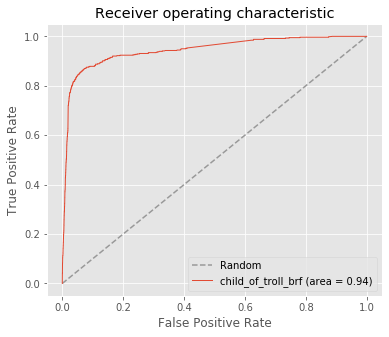

In [44]:
fig, ax = plt.subplots(1, figsize=(6, 5))
plot_roc_nofit(ax, Xcsd_test, y_test, clfs['cot_brf'], 'child_of_troll_brf')

### pickle this model

In [46]:
filename = 'child_of_troll_brf.pkl'
with open(filename, 'wb') as fp:
    pickle.dump(clfs['cot_brf'], fp)

### test de-pickle

In [47]:
with open('child_of_troll_brf.pkl', 'rb') as fp:
    new_brf = pickle.load(fp)

<ipython-input-39-4bcd29495c04>:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


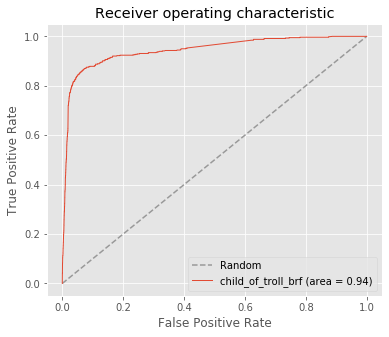

In [49]:
fig, ax = plt.subplots(1, figsize=(6, 5))
plot_roc_nofit(ax, Xcsd_test, y_test, new_brf, 'child_of_troll_brf')

## now train model for troll?
first, without using any info from child_of_troll classification

In [52]:
# X doesn't change, but y does

_, _, y_train, y_test = train_test_split(
        corpus, comms['troll?'], test_size=0.2, random_state=30, shuffle=True)

In [53]:
brf = BalancedRandomForestClassifier(**model_param, class_weight='balanced_subsample')
brf.fit(Xcsd_train, y_train)

/home/ubuntu/miniconda3/envs/ipy/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:591: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


BalancedRandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                               class_weight='balanced_subsample',
                               criterion='gini', max_depth=5, max_features=25,
                               max_leaf_nodes=None, max_samples=None,
                               min_impurity_decrease=0.0, min_samples_leaf=2,
                               min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=400,
                               n_jobs=-1, oob_score=True, random_state=30,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

In [54]:
# measure accuracy
print("\n R^2 score:", brf.score(Xcsd_test, y_test))
print(f'\n Out of bag score: {brf.oob_score_}')
y_predict = brf.predict(Xcsd_test)
np.sum(y_predict)


 R^2 score: 0.5818768428699628

 Out of bag score: 0.6234288804759329


20273

In [55]:
print("\n precision:", precision_score(y_test, y_predict))
print("    recall:", recall_score(y_test, y_predict))


 precision: 0.049819957579046024
    recall: 0.7674772036474165


<ipython-input-39-4bcd29495c04>:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


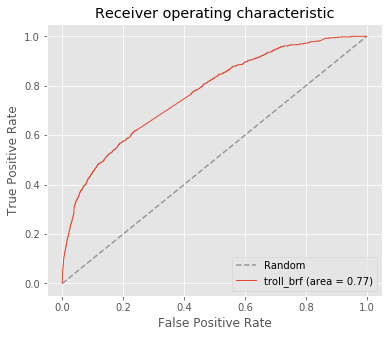

In [56]:
# using the depth added about 5% to auc
fig, ax = plt.subplots(1, figsize=(6, 5))
plot_roc_nofit(ax, Xcsd_test, y_test, brf, 'troll_brf')

### pickle this model

In [57]:
filename = 'troll_brf.pkl'
with open(filename, 'wb') as fp:
    pickle.dump(brf, fp)

In [ ]:
# fit the model
brf = BalancedRandomForestClassifier(**model_param, class_weight='balanced_subsample')
t0 = time.time()
print('fit classifier...')
brf.fit(af_X_train, y_train)
print("done in %0.3fs." % (time.time() - t0))

# evaluate model
# measure accuracy
print("\n R^2 score:", brf.score(af_X_test, y_test))
print(f'Out of bag score: {brf.oob_score_}')
y_predict = brf.predict(af_X_test)
print(f'Number of positive predictions: {np.sum(y_predict)}')
# precision and recall
print("\n precision:", precision_score(y_test, y_predict))
print("    recall:", recall_score(y_test, y_predict))

fig, ax = plt.subplots(1, figsize=(6, 5))
for label, clf in clfs.items():
    plot_roc_nofit(ax, X_test, y_test, clf, label)

return brf

In [ ]:
# initialize classifiers
clfs = {}
tfidf_param = {'max_df': 0.95, 
               'min_df': 2, 
               'max_features': 5000, 
               'stop_words': 'english'}

model_param = {'n_estimators': 400,
                   'max_depth': 5,
                   'max_features': 25,
                   'oob_score': True,
                   'n_jobs': -1,
                   'random_state': 30}

X = corpus
add_feat = [
        'controversiality', 'score', 'norm_depth'
    ]

In [ ]:
# learn whether comment is a reply to a troll
target = 'child_of_troll?'
ydf = comms[[target] + add_feat]
clfs[target + '_brf'] = balanced_random_forest_pipeline(
            X, 
            ydf, 
            target, 
            tfidf_param,
            model_param,
            additional_features=add_feat,
            compare_with=None)

### example PSAW pushshift code to get multiple comments at once

In [ ]:
api = PushshiftAPI()

In [ ]:
gen = api.search_comments(id='cax4ng0,cax1t9x')
next(gen).d_, next(gen).d_

### example PRAW code for getting multiple subreddits with the same search from reddit

In [ ]:
gen = reddit.subreddits.search("t5_2r99w,t5_2r99w")
next(gen), next(gen)

### code to bring the subreddit id and the name of the subreddit together

In [ ]:
dict(zip(comms['subreddit_id'], comms['subreddit']))

In [ ]:
# np.unique(comms['subreddit_id'] + '_' + comms['subreddit'], return_counts=True)
comms['subreddit_id']

### explore comment ids for troll comments

In [ ]:
troll_comments = comms[comms['troll?']==1]

In [ ]:
len(troll_comments)

In [ ]:
# let's get the ids for all the troll_comments, then retrieve all the replies to it from Pushshift
troll_comments['id']

### explore comments in /r/politics

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    troll_comments = comms[comms['troll?']==1]
    print(troll_comments[troll_comments['subreddit']=='politics'])
# comms.tail().iloc[0, :]

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    not_troll_comments = comms[comms['troll?']!=1]
    print(not_troll_comments[not_troll_comments['subreddit_id']=='t5_2cneq'].head())

### number of troll comments in reply to other trolls...

In [ ]:
np.logical_and(comms['troll?']==1, comms['parent_of_troll?']==1).sum()

In [ ]:
    outcols = df.columns + ['comm_type']
    # allow for extra columns after depth, nest_level, and parent_id
    if list(df.columns)[:3] != ['depth', 'nest_level', 'parent_id']:
        raise
    outdf = pd.DataFrame(np.hstack([
        df.values, 
        np.array([
            x.split('_')[0] for x in df['parent_id'].values
        ])
        .reshape(-1, 1)
    ]), columns=outcols)
    outdf['depth'] = outdf['depth'].astype(float)
    outdf['nest_level'] = outdf['nest_level'].astype(float)
    if 'troll?' in outcols:
        outdf['troll?'] = outdf['troll?'].astype(int)
    return outdf

In [ ]:
clfs